In [2]:
import pandas as pd
import numpy as np
import os
import glob

import PIL
from PIL import Image
import imageio

import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import seaborn as sn
import numpy as np
import pathlib

In [3]:
data_dir = '/kaggle/input/brain-tumor-detection'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Image Count: ",image_count)

Image Count:  3060


## Create DataSet

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3060 files belonging to 3 classes.
Using 2448 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3060 files belonging to 3 classes.
Using 612 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['no', 'pred', 'yes']


In [8]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9903403


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Building

In [11]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(255, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

hist = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=8
)

Epoch 1/8
77/77 [==============================] - 60s 767ms/step - loss: 0.6121 - accuracy: 0.7169 - val_loss: 0.4348 - val_accuracy: 0.8529
Epoch 2/8
77/77 [==============================] - 55s 716ms/step - loss: 0.3590 - accuracy: 0.8539 - val_loss: 0.3240 - val_accuracy: 0.9150
Epoch 3/8
77/77 [==============================] - 55s 720ms/step - loss: 0.2070 - accuracy: 0.9350 - val_loss: 0.2846 - val_accuracy: 0.9297
Epoch 4/8
77/77 [==============================] - 56s 722ms/step - loss: 0.1301 - accuracy: 0.9596 - val_loss: 0.2747 - val_accuracy: 0.9379
Epoch 5/8
77/77 [==============================] - 56s 720ms/step - loss: 0.0808 - accuracy: 0.9757 - val_loss: 0.3892 - val_accuracy: 0.9395
Epoch 6/8
77/77 [==============================] - 55s 720ms/step - loss: 0.0695 - accuracy: 0.9787 - val_loss: 0.4330 - val_accuracy: 0.9346
Epoch 7/8
77/77 [==============================] - 55s 714ms/step - loss: 0.0655 - accuracy: 0.9795 - val_loss: 0.3694 - val_accuracy: 0.9395
Epoch 

## Model Summary

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 32)       

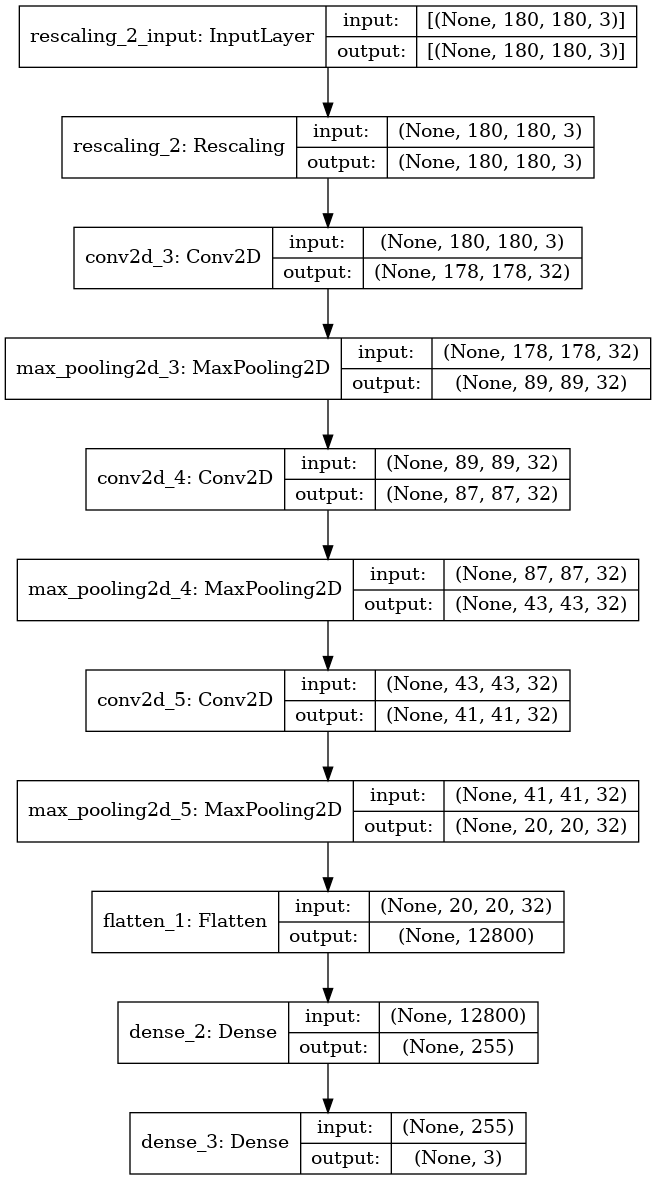

In [21]:
tf.keras.utils.plot_model(model,  show_shapes=True,expand_nested=True)

## Val Data Check

In [14]:
normalized_vds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [15]:
predictions = np.array([])
labels =  np.array([])
for x, y in normalized_vds:
  predictions = np.concatenate([predictions, hist.model.predict_classes(x)])
  labels = np.concatenate([labels, y.numpy()])

df_check = pd.DataFrame({'Actual':labels.round(0).astype(int), 'Pred':predictions.round()})
df_check['C'] = np.where(
    df_check['Actual'] == df_check['Pred'], 1, 0) 

df_check['C'].value_counts()
acc = df_check['C'].sum() / df_check['C'].size

print('Accurarcy of Model on Val: ', acc)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accurarcy of Model on Val:  0.4869281045751634


## Accuracy Plot

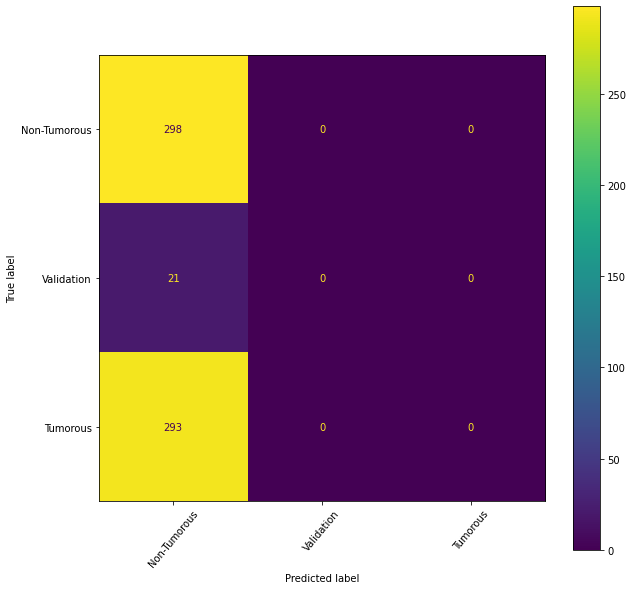

In [16]:
cm = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
ls = ['Non-Tumorous','Validation', 'Tumorous'] # your y labels()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation=50, ax = ax)
plt.show()

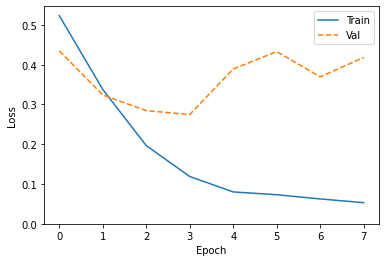

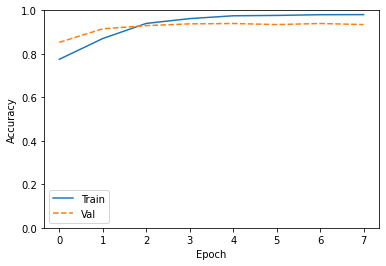

In [17]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    try:
      name = metric.replace("_"," ").capitalize()
      plt.plot(history.epoch, history.history[metric], label='Train')
      plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
      plt.xlabel('Epoch')
      plt.ylabel(name)
      if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
      elif metric == 'auc':
        plt.ylim([0.8,1])
      else:
        plt.ylim([0,1])
      plt.legend()
      plt.show()  
    except:
      pass
plot_metrics(hist)

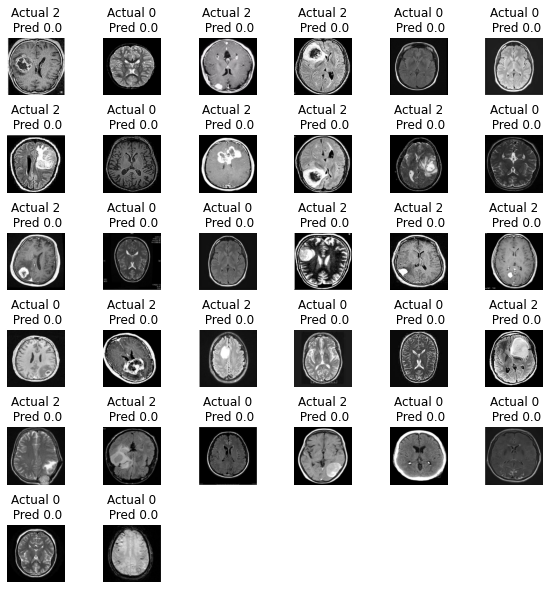

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.subplots_adjust(hspace= 0.7)
        plt.imshow(images[i].numpy().astype("uint8"))
        act_lab = labels.numpy()[i]
        pred_lab = predictions[i]
        title = "Actual {}\n Pred {}".format(act_lab,pred_lab)
        plt.title(title)
        plt.axis("off")
    plt.show()